In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import xarray as xr

from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt

from fme_diags.utils import get_run_kwargs, load_config, open_autoregressive_inference
from fme_diags.zonal_spectrum import compute_zonal_time_mean_spectrum, plot_zonal_time_mean_spectra

_ = xr.set_options(keep_attrs=True)

In [2]:
if not "RUN_KEY" in os.environ:
    RUN_KEY = "42yrs-batch_size8-max_epochs50-lr3e-4-run4"
else:
    RUN_KEY = os.environ["RUN_KEY"]

In [3]:
config = load_config("preds.yaml")
run_kwargs = get_run_kwargs(config, RUN_KEY)
run_kwargs

{'path': '/pscratch/sd/j/jpduncan/ai2/datasets/2023-11-22-e3smv2-vertically-resolved-1deg-fme-dataset/output/42-years-training-set/42yrs-batch_size8-max_epochs50-lr3e-4-run4/autoregressive_predictions.nc',
 'start': '0054-01-01',
 'step_dim': 'lead',
 'step_freq': '6H',
 'calendar': 'noleap',
 'flip_lat': False,
 'chunks': {'lead': 178}}

In [4]:
FIG_PREFIX = "daily-precip-zonal-mean-spectrum"
OUTDIR = f"figs/{RUN_KEY}"
os.makedirs(OUTDIR, exist_ok=True)

In [5]:
ds = open_autoregressive_inference(**run_kwargs)
ds

<xarray.Dataset>
Dimensions:                                        (time: 14597, sample: 1,
                                                    source: 2, lat: 180,
                                                    lon: 360)
Coordinates:
  * time                                           (time) object 0054-01-01 0...
    init                                           (sample) object dask.array<chunksize=(1,), meta=np.ndarray>
    valid_time                                     (sample, time) object dask.array<chunksize=(1, 178), meta=np.ndarray>
  * source                                         (source) object 'target' '...
  * lat                                            (lat) float32 89.24 ... -8...
  * lon                                            (lon) float32 0.5 ... 359.5
Dimensions without coordinates: sample
Data variables: (12/49)
    surface_upward_shortwave_flux                  (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    specific_total_water_7                         (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    PHIS                                           (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    T_3                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    T_6                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    U_3                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    ...                                             ...
    V_2                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    V_6                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    LHFLX                                          (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    TS                                             (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    FSDS                                           (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    specific_total_water_4                         (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>

In [6]:
da = ds["surface_precipitation_rate"].isel(sample=0)

with ProgressBar():
    da = da.resample(time="1D").mean("time").compute()

[########################################] | 100% Completed |  5.8s


No latitude weighting:

In [7]:
%%time

# (mean, std)
precip_zonal_mean_spectrum = compute_zonal_time_mean_spectrum(da)

CPU times: user 9.17 s, sys: 5.23 s, total: 14.4 s
Wall time: 14.5 s


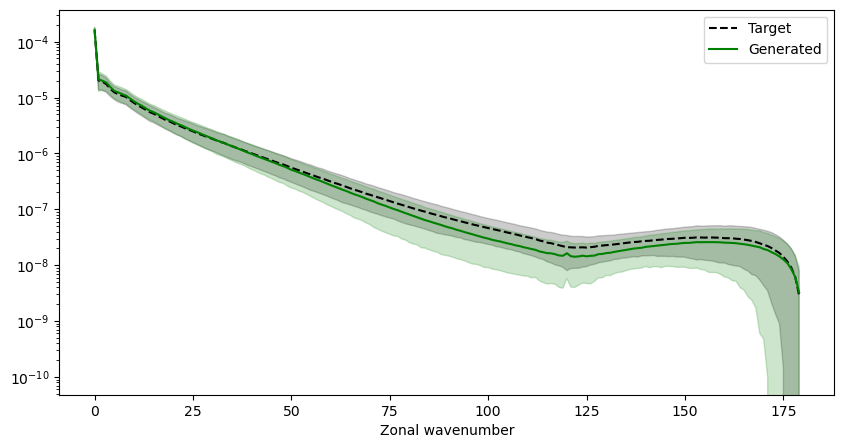

In [8]:
fig, ax = plot_zonal_time_mean_spectra(
    precip_zonal_mean_spectrum[0], # mean 
    precip_zonal_mean_spectrum[1], # std
    wavenumber_slice=slice(0, 179),
    # stderr=True,
)
fig.show()

In [9]:
fig.savefig(os.path.join(OUTDIR, f"{FIG_PREFIX}_fig1.png"), bbox_inches="tight")

With latitude weighting:

In [10]:
%%time

lat_weights = np.cos(np.deg2rad(da["lat"]))
lat_weighted_precip_zonal_mean_spectrum = compute_zonal_time_mean_spectrum(da, lat_weights)

CPU times: user 7.83 s, sys: 4.7 s, total: 12.5 s
Wall time: 12.5 s


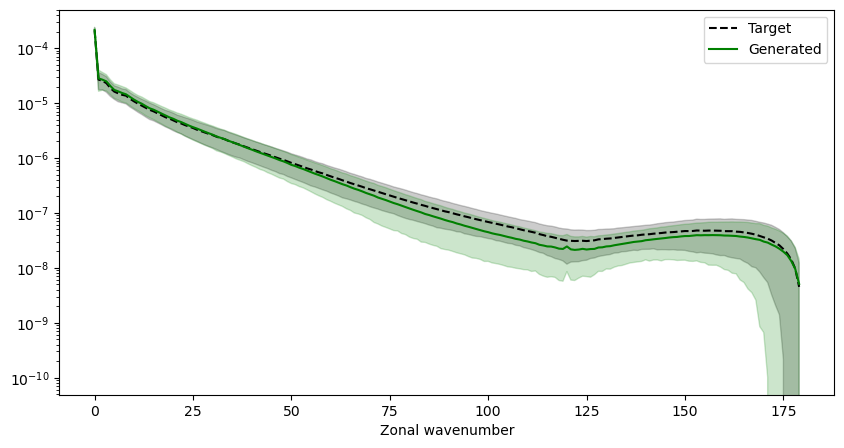

In [11]:
fig, ax = plot_zonal_time_mean_spectra(
    lat_weighted_precip_zonal_mean_spectrum[0], # mean
    lat_weighted_precip_zonal_mean_spectrum[1], # std
    wavenumber_slice=slice(0, 179),
)
fig.show()

In [12]:
fig.savefig(os.path.join(OUTDIR, f"{FIG_PREFIX}_fig2.png"), bbox_inches="tight")

In tropics:

In [13]:
da_tropics = da.sel(lat=slice(15, -15))
precip_tropics_zonal_mean_spectrum = compute_zonal_time_mean_spectrum(da_tropics)

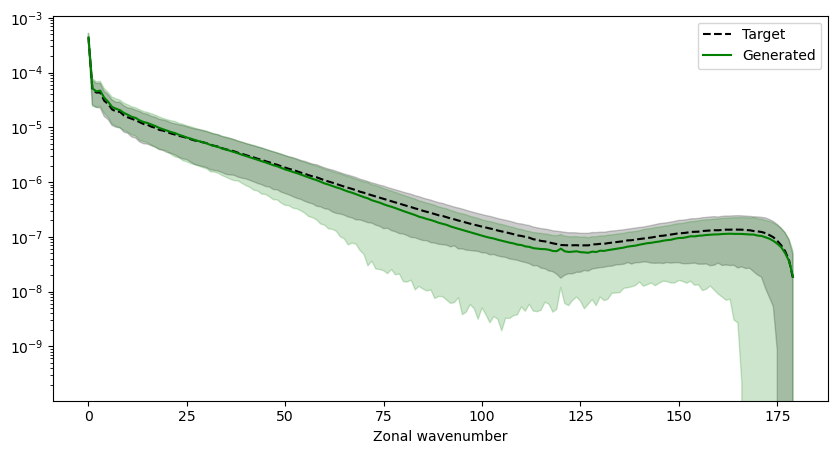

In [14]:
fig, ax = plot_zonal_time_mean_spectra(
    precip_tropics_zonal_mean_spectrum[0],
    precip_tropics_zonal_mean_spectrum[1],
    wavenumber_slice=slice(0, 179),
)
fig.show()

In [15]:
fig.savefig(os.path.join(OUTDIR, f"{FIG_PREFIX}_fig3.png"), bbox_inches="tight")

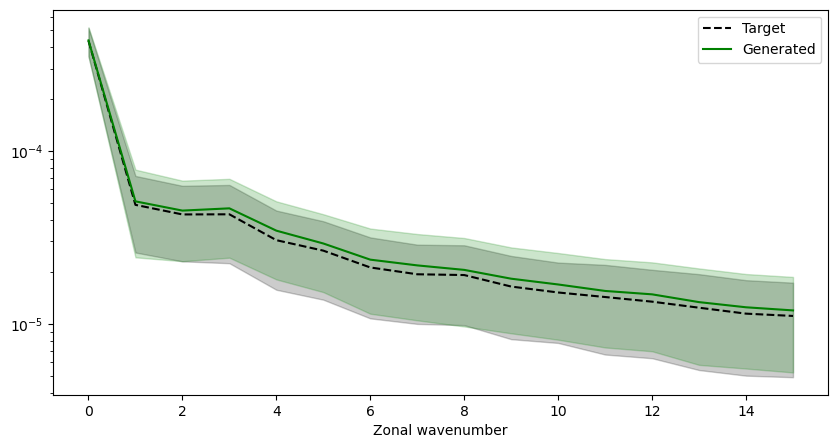

In [16]:
fig, ax = plot_zonal_time_mean_spectra(
    precip_tropics_zonal_mean_spectrum[0],
    precip_tropics_zonal_mean_spectrum[1],
    wavenumber_slice=slice(0, 15),
)
fig.show()

In [17]:
fig.savefig(os.path.join(OUTDIR, f"{FIG_PREFIX}_fig4.png"), bbox_inches="tight")

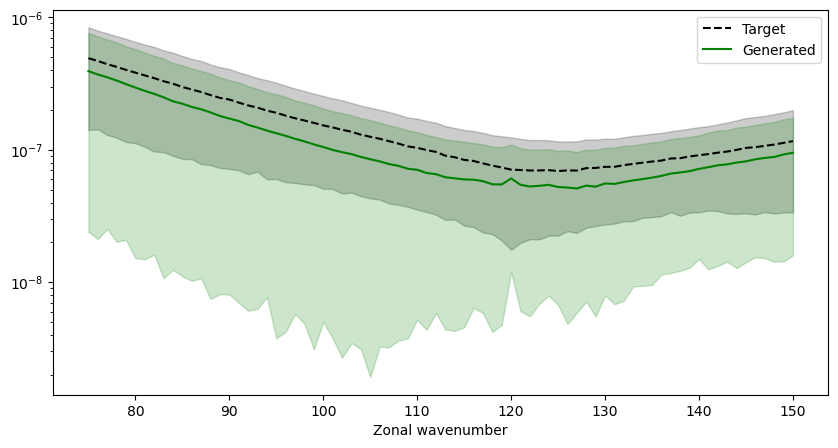

In [18]:
fig, ax = plot_zonal_time_mean_spectra(
    precip_tropics_zonal_mean_spectrum[0],
    precip_tropics_zonal_mean_spectrum[1],
    wavenumber_slice=slice(75, 150),
)
fig.show()

In [19]:
fig.savefig(os.path.join(OUTDIR, f"{FIG_PREFIX}_fig5.png"), bbox_inches="tight")